In [1]:
from datascience import *
import numpy as np
import math
import scipy.stats as stats

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

This homework uses the file `baby.csv`, presented in class.  Show your results for the following questions.

In [2]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


## Problem 1

##### 1. Calculate the 90% confidence interval for the <font color=red>median</font> Maternal BMI (body mass index), using the bootstrap method.

The formula for BMI is $$\frac{\text{Weight (lb)}}{\text{[height (in)]}^2} \times 703$$.

21.2822265625

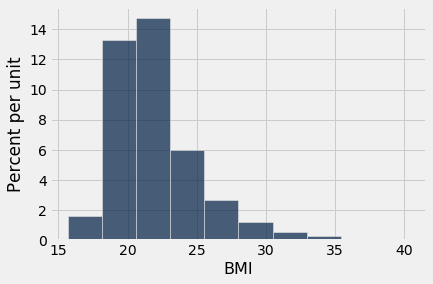

In [3]:
births1= births.with_column('BMI', (births.column('Maternal Pregnancy Weight')*703)/
                            births.column('Maternal Height')**2)
births1.select('BMI').hist();
np.median(births1.column(6))

In [4]:
def bootstrap_median(sample, variableLabel, numBootstrap):
    compensation = sample.select(variableLabel)
    medians = make_array()
    for i in np.arange(numBootstrap):
        bootstrap_sample = compensation.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)

    return medians

In [5]:
bstrap_medians = bootstrap_median(births1, 'BMI', 5000)
left = percentile(5, bstrap_medians)  
right = percentile(95, bstrap_medians)
make_array(left, right)

array([21.14167966, 21.45385742])

The 90% confidence interval for the median Maternal BMI is [21.14167966, 21.45385742]

##### 2.  Calculate the 80% confidence interval for the proportion of mothers who smoked using the bootstrap method.

In [6]:
smoking = births.column('Maternal Smoker')
np.count_nonzero(smoking)/len(smoking)

0.3909710391822828

In [7]:
def bootstrap_proportion(sample, variableLabel, numBootstrap):
    compensation = sample.select(variableLabel)
    proportion = make_array()
    for i in np.arange(numBootstrap):
        bootstrap_sample = compensation.sample()
        resampled_proportion = bootstrap_sample.column(0)
        resampled_proportion = np.count_nonzero(resampled_proportion)/len(resampled_proportion)
        proportion = np.append(proportion, resampled_proportion)

    return proportion

In [8]:
bstrap_proportion = bootstrap_proportion(births, 'Maternal Smoker', 5000)
left = percentile(10, bstrap_proportion)  
right = percentile(90, bstrap_proportion)
make_array(left, right)

array([0.37308348, 0.4088586 ])

the 80% confidence interval for the proportion of mothers who smoked is [0.37308348, 0.40971039]

## Problem 2

##### 1. Use permutation test to test the following hypotheses using the ratio of the variances as the test statistic.

* $H_0$: The variance of `Birth Weight` is the same as for mothers who smoke and mothers who do not smoke.
* $H_1$:The variance of `Birth Weight` is diferent between mothers who smoke and mothers who do not smoke.

(Note: We saw how to test these hypothesis using the F-ratio test in class.)

In [9]:
births2 = births.select('Maternal Smoker', 'Birth Weight')
var_table = births2.group('Maternal Smoker', (lambda x: np.std(x,ddof=1)**2))
var_table

Maternal Smoker,Birth Weight
False,303.585
True,334.707


In [10]:
def difference_of_var(table, label, group_label):
    reduced = table.select(label, group_label)
    var_table = reduced.group(group_label, (lambda x: np.std(x,ddof=1)**2))
    var = var_table.column(1)
    return var.item(1)/var.item(0)

In [11]:
observed_difference = difference_of_var(births, 'Birth Weight', 'Maternal Smoker')
observed_difference

1.1025157408199457

In [12]:
shuffled_labels = births2.sample(with_replacement = False).column(0)
original_and_shuffled = births2.with_column('Shuffled Label', shuffled_labels)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,True
True,128,True
True,108,False
False,136,True
False,138,True
False,132,False
False,120,False
True,143,False
False,140,True


In [13]:
shuffled_only = original_and_shuffled.drop('Maternal Smoker')
shuffled_group_var = shuffled_only.group('Shuffled Label', (lambda x: np.std(x,ddof=1)**2))
shuffled_group_var

Shuffled Label,Birth Weight
False,323.764
True,353.538


In [14]:
difference_of_var(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

1.0919621919653895

In [15]:
def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    shuffled_table = table.select(label).with_column('Shuffled Label', shuffled_labels)
    return difference_of_var(shuffled_table, label, 'Shuffled Label')   

In [16]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

0.9140281033709216

In [17]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)  

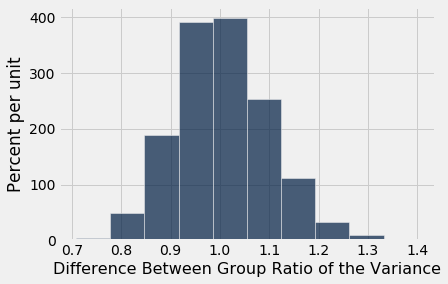

In [18]:
diffTable = Table().with_column('Difference Between Group Ratio of the Variance', differences)
diffTable.hist()

In [19]:
empirical_P = 2*np.count_nonzero(differences >= observed_difference) / repetitions
empirical_P

0.2996

The p-value is more than 0.05, we can not reject the null hypotheses. The test supports the null hypothesis that the variance of Birth Weight is the same as for mothers who smoke and mothers who do not smoke.